In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

In [12]:
with open('../data/wikitexts.md', 'r') as file:
    corpus = file.read()

In [3]:
min_chunk_size = 50
splitter = RecursiveCharacterTextSplitter(
    chunk_size=min_chunk_size,
    chunk_overlap=0,
    length_function=num_tokens_from_string
    )

In [36]:
docs = splitter.split_text(corpus)

In [5]:
len(sentences)

661

In [17]:
from openai import OpenAI
import os
import numpy as np

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

# response = client.embeddings.create(
#     input=docs,
#     model="text-embedding-3-large"
# )

In [19]:
def similarity_check(current_chunk, next_chunk) -> bool:
    response = client.embeddings.create(
        input=[current_chunk, next_chunk],
        model="text-embedding-3-large"
    )

    embedding1 = response.data[0].embedding
    embedding2 = response.data[1].embedding

    cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    if cosine_similarity > 0.8:
        return True
    
    # if len(current_chunk) < 200:
    #     return True
    return False
    # return tiktoken.similarity(current_chunk, next_chunk, "cl100k_base"

sentences = splitter.split_text(corpus)
sentences = list(reversed(sentences))

docs = []
total_sentences = len(sentences)
current_chunk = sentences.pop()
while sentences:
    next_chunk = sentences.pop()
    if similarity_check(current_chunk, next_chunk):
        current_chunk += next_chunk
    else:
        docs.append(current_chunk)
        current_chunk = next_chunk
    progress = (total_sentences - len(sentences)) / total_sentences * 100
    print(f"Progress: {progress:.2f}%")
docs.append(current_chunk)

Progress: 0.30%
Progress: 0.45%
Progress: 0.61%
Progress: 0.76%
Progress: 0.91%
Progress: 1.06%
Progress: 1.21%
Progress: 1.36%
Progress: 1.51%
Progress: 1.66%
Progress: 1.82%
Progress: 1.97%
Progress: 2.12%
Progress: 2.27%
Progress: 2.42%
Progress: 2.57%
Progress: 2.72%
Progress: 2.87%
Progress: 3.03%
Progress: 3.18%
Progress: 3.33%
Progress: 3.48%
Progress: 3.63%
Progress: 3.78%
Progress: 3.93%
Progress: 4.08%
Progress: 4.24%
Progress: 4.39%
Progress: 4.54%
Progress: 4.69%
Progress: 4.84%
Progress: 4.99%
Progress: 5.14%
Progress: 5.30%
Progress: 5.45%
Progress: 5.60%
Progress: 5.75%
Progress: 5.90%
Progress: 6.05%
Progress: 6.20%
Progress: 6.35%
Progress: 6.51%
Progress: 6.66%
Progress: 6.81%
Progress: 6.96%
Progress: 7.11%
Progress: 7.26%
Progress: 7.41%
Progress: 7.56%
Progress: 7.72%
Progress: 7.87%
Progress: 8.02%
Progress: 8.17%
Progress: 8.32%
Progress: 8.47%
Progress: 8.62%
Progress: 8.77%
Progress: 8.93%
Progress: 9.08%
Progress: 9.23%
Progress: 9.38%
Progress: 9.53%
Progress

KeyboardInterrupt: 

In [25]:
sentences = splitter.split_text(corpus)

response = client.embeddings.create(
    input=sentences,
    model="text-embedding-3-large"
)

N = len(sentences)
embedding_matrix = np.zeros((N, len(response.data[0].embedding)))

# Populate the embedding matrix
for i, embedding_obj in enumerate(response.data):
    embedding = np.array(embedding_obj.embedding)
    embedding_matrix[i] = embedding

dot_product_matrix = np.dot(embedding_matrix, embedding_matrix.T)

In [26]:
neighbour_similarities = []
for i in range(N-1):
    neighbour_similarities.append(dot_product_matrix[i, i+1])

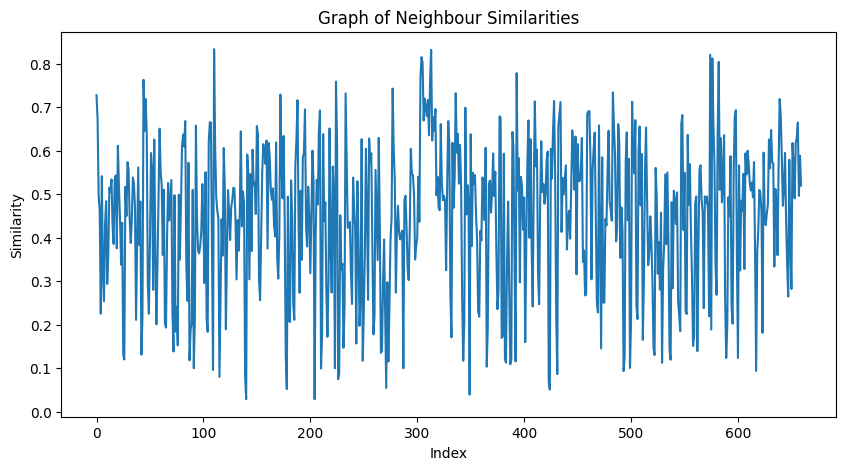

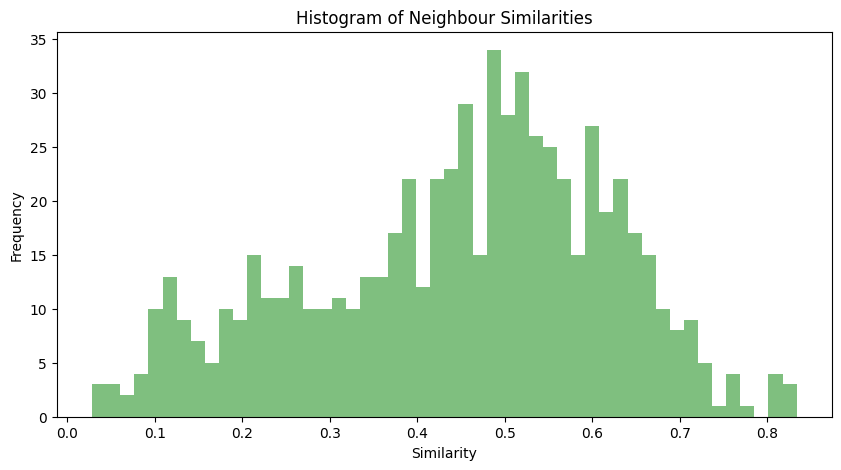

Mean of Neighbour Similarities: 0.44666487064967847
Median of Neighbour Similarities: 0.47653702286607
Min of Neighbour Similarities: 0.028338573562017914
Max of Neighbour Similarities: 0.8333918972686637
Standard Deviation of Neighbour Similarities: 0.17207791850940965


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the graph of neighbour_similarities
plt.figure(figsize=(10, 5))
plt.plot(neighbour_similarities)
plt.title('Graph of Neighbour Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.show()

# Plotting the histogram of neighbour_similarities
plt.figure(figsize=(10, 5))
plt.hist(neighbour_similarities, bins=50, alpha=0.5, color='g')
plt.title('Histogram of Neighbour Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

# Calculating and printing the mean, median, min, max and std of neighbour_similarities
mean_val = np.mean(neighbour_similarities)
median_val = np.median(neighbour_similarities)
min_val = np.min(neighbour_similarities)
max_val = np.max(neighbour_similarities)
std_val = np.std(neighbour_similarities)

print(f"Mean of Neighbour Similarities: {mean_val}")
print(f"Median of Neighbour Similarities: {median_val}")
print(f"Min of Neighbour Similarities: {min_val}")
print(f"Max of Neighbour Similarities: {max_val}")
print(f"Standard Deviation of Neighbour Similarities: {std_val}")


# Goals
1. Re-visit Greg's algorithm. Fully understand it.
2. Assess how it can be modify to deal with large texts and chunk max sizes.
3. Consider how we can then do a pinecone style one.

In [37]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(docs)]

In [38]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences, 3)

In [39]:
sentences

[{'sentence': '= Valkyria Chronicles III =',
  'index': 0,
  'combined_sentence': '= Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan'},
 {'sentence': 'Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as',
  'index': 1,
  'combined_sentence': '= Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valk

In [40]:
combine_sentences = [x['combined_sentence'] for x in sentences]

In [41]:
combine_sentences[0]

'= Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan'

In [46]:
len(sentences)

661

In [45]:
response = client.embeddings.create(
    input=combine_sentences,
    model="text-embedding-3-large"
)

In [47]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = response.data[i].embedding

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [49]:

distances, sentences = calculate_cosine_distances(sentences)

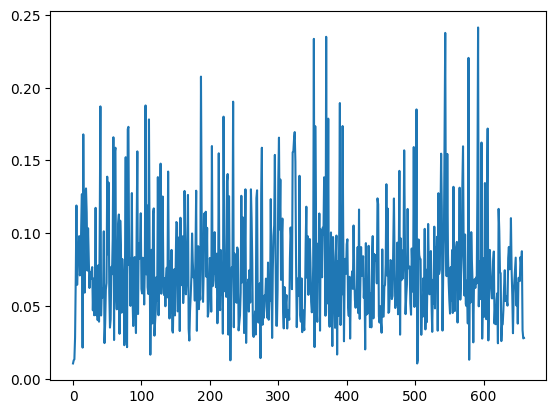

In [51]:
import matplotlib.pyplot as plt

plt.plot(distances);


In [55]:
total_tokens = sum(len(sentence['combined_sentence'].split()) for sentence in sentences)


In [56]:
total_tokens

156482

In [57]:
avg_chunk_size = 400

number_of_cuts = total_tokens // avg_chunk_size

print(f"Total tokens: {total_tokens}")
print(f"Average chunk size: {avg_chunk_size}")
print(f"Number of cuts: {number_of_cuts}")

Total tokens: 156482
Average chunk size: 400
Number of cuts: 391


In [58]:
import numpy as np

# Define threshold limits
lower_limit = 0.0
upper_limit = 1.0

# Convert distances to numpy array
distances_np = np.array(distances)

# Binary search for threshold
while upper_limit - lower_limit > 1e-6:
    threshold = (upper_limit + lower_limit) / 2.0
    num_points_above_threshold = np.sum(distances_np > threshold)
    
    if num_points_above_threshold > number_of_cuts:
        lower_limit = threshold
    else:
        upper_limit = threshold

print(f"Threshold that gives {number_of_cuts} cuts: {threshold}")


Threshold that gives 391 cuts: 0.06229114532470703


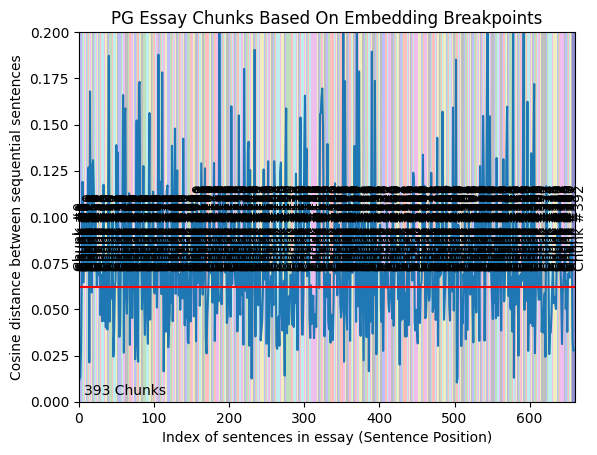

In [59]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

breakpoint_distance_threshold = threshold
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [60]:

# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)


In [62]:
chunks[0]

'= Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .'

In [61]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
= Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is
...
llows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .


Chunk #1
The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjus
...
a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for




In [28]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

# collection_name = "questions_openai_large"
collection_name = "auto_chunk"

# collection = chroma_client.create_collection(collection_name)
collection = chroma_client.get_collection(collection_name, embedding_function=openai_ef)

In [29]:
all = collection.get()

In [26]:
splitter = GreggImprovedChunker(avg_chunk_size=300)

docs = splitter.split_text(corpus)

Total tokens: 26461
Average chunk size: 400
Number of cuts: 66


In [31]:
import numpy as np

docs = all['documents']

tokens = [num_tokens_from_string(x) for x in docs]

mean_tokens = np.mean(tokens)
median_tokens = np.median(tokens)
min_tokens = np.min(tokens)
max_tokens = np.max(tokens)
std_tokens = np.std(tokens)

print(f"Mean: {mean_tokens}")
print(f"Median: {median_tokens}")
print(f"Min: {min_tokens}")
print(f"Max: {max_tokens}")
print(f"Standard Deviation: {std_tokens}")


Mean: 298.71271729185725
Median: 180.0
Min: 2
Max: 4268
Standard Deviation: 384.10229914186345


In [23]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
from openai import OpenAI
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class GreggImprovedChunker():
    def __init__(self, avg_chunk_size=400, min_chunk_size=50, BERT=False):
        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=min_chunk_size,
            chunk_overlap=0,
            length_function=num_tokens_from_string
            )
        
        self.avg_chunk_size = avg_chunk_size

    def combine_sentences(self, sentences, buffer_size=1):
        # Go through each sentence dict
        for i in range(len(sentences)):

            # Create a string that will hold the sentences which are joined
            combined_sentence = ''

            # Add sentences before the current one, based on the buffer size.
            for j in range(i - buffer_size, i):
                # Check if the index j is not negative (to avoid index out of range like on the first one)
                if j >= 0:
                    # Add the sentence at index j to the combined_sentence string
                    combined_sentence += sentences[j]['sentence'] + ' '

            # Add the current sentence
            combined_sentence += sentences[i]['sentence']

            # Add sentences after the current one, based on the buffer size
            for j in range(i + 1, i + 1 + buffer_size):
                # Check if the index j is within the range of the sentences list
                if j < len(sentences):
                    # Add the sentence at index j to the combined_sentence string
                    combined_sentence += ' ' + sentences[j]['sentence']

            # Then add the whole thing to your dict
            # Store the combined sentence in the current sentence dict
            sentences[i]['combined_sentence'] = combined_sentence

        return sentences

    def calculate_cosine_distances(self, sentences):
        distances = []
        for i in range(len(sentences) - 1):
            embedding_current = sentences[i]['combined_sentence_embedding']
            embedding_next = sentences[i + 1]['combined_sentence_embedding']
            
            # Calculate cosine similarity
            similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
            
            # Convert to cosine distance
            distance = 1 - similarity

            # Append cosine distance to the list
            distances.append(distance)

            # Store distance in the dictionary
            sentences[i]['distance_to_next'] = distance

        # Optionally handle the last sentence
        # sentences[-1]['distance_to_next'] = None  # or a default value

        return distances, sentences

    def split_text(self, text):
        sentences_strips = self.splitter.split_text(text)

        sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences_strips)]

        sentences = self.combine_sentences(sentences, 3)

        combined_sentences = [x['combined_sentence'] for x in sentences]

        OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
        client = OpenAI(api_key=OPENAI_API_KEY)

        BATCH_SIZE = 400
        for i in range(0, len(combined_sentences), BATCH_SIZE):
            batch_sentences = combined_sentences[i:i+BATCH_SIZE]
            response = client.embeddings.create(
                input=batch_sentences,
                model="text-embedding-3-large"
            )

            for j, sentence in enumerate(sentences[i:i+BATCH_SIZE]):
                sentence['combined_sentence_embedding'] = response.data[j].embedding

        distances, sentences = self.calculate_cosine_distances(sentences)

        total_tokens = sum(num_tokens_from_string(sentence['sentence']) for sentence in sentences)
        avg_chunk_size = self.avg_chunk_size
        number_of_cuts = total_tokens // avg_chunk_size

        # Define threshold limits
        lower_limit = 0.0
        upper_limit = 1.0

        # Convert distances to numpy array
        distances_np = np.array(distances)

        # Binary search for threshold
        while upper_limit - lower_limit > 1e-6:
            threshold = (upper_limit + lower_limit) / 2.0
            num_points_above_threshold = np.sum(distances_np > threshold)
            
            if num_points_above_threshold > number_of_cuts:
                lower_limit = threshold
            else:
                upper_limit = threshold

        indices_above_thresh = [i for i, x in enumerate(distances) if x > threshold] 
        
        # Initialize the start index
        start_index = 0

        # Create a list to hold the grouped sentences
        chunks = []

        # Iterate through the breakpoints to slice the sentences
        for index in indices_above_thresh:
            # The end index is the current breakpoint
            end_index = index

            # Slice the sentence_dicts from the current start index to the end index
            group = sentences[start_index:end_index + 1]
            combined_text = ' '.join([d['sentence'] for d in group])
            chunks.append(combined_text)
            
            # Update the start index for the next group
            start_index = index + 1

        # The last group, if any sentences remain
        if start_index < len(sentences):
            combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
            chunks.append(combined_text)

        return chunks